# HW 4: recurrent neural networks

In this assignment, you'll create a model with LSTM or GRU to predict the indices of S&P 500

## Dataset and Objectives

A time series containing the indices of S&P 500 from 2010 to 2017 can be found at <a href = "https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables"> UCI Machine Data Repository</a>. A detailed description of the dataset can be found <a href = "https://www.researchgate.net/profile/Ehsan-Hoseinzade/publication/331911968_CNNpred_CNN-based_stock_market_prediction_using_a_diverse_set_of_variables/links/5cb07442299bf120975fd0fd/CNNpred-CNN-based-stock-market-prediction-using-a-diverse-set-of-variables.pdf">here (see pages 31-32)</a>. A snippet of the data is shown below. 

You're required to build a model to predict the daily `close` indices. From the plot, you can find that the indices fluctuate from day to day.

The exact formulation of our problem will be the following: given data going as far back as `L (lookback)` timesteps, we predict the targets in the next `N` days. The following figure illustrate `L = 24, N = 24`.

<img src='https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png' width = '60%'>

By this method, your samples $(X, Y)$ should be as follows (e.g. `L = 24, N=24` in the above figure):

| id | X | Y  |
|-- |:---|:---|
|0 | $$ [x_0, x_1, ..., x_{L-1}]$$ | $$[x_{L}, x_{L+1}, x_{L+2}, ..., x_{L+N-1}]$$|
|1 | $$ [x_1, x_2, ..., x_L]$$ | $$[x_{L+1}, x_{L+2}, x_{L+3}, ..., x_{L+N}]$$|
|2 | $$ [x_2, x_3, ..., x_{L+1}]$$ | $$[x_{L+2}, x_{L+3}, x_{L+4}, ..., x_{L+N+1}]$$|
|... |... |...|



We would like to make two predictions:
- **Regression**: the `Close` index of the next day
- **Binary Classification**: 1 if the `Close index of the next day` is higher than the current day, and 0 otherwise. This can be considered as the trading strategy `Buy or Hold`.

There are a number of useful features in the dataset, e.g. `change of volume`, `moving average` etc. For demonstration, I just show a few of them below.

For simplicity, let's set `L = 5, N = 1`, i.e. predict the next day Close index by the information from the past 5 days. In bonus, you can try to predict prices in the next 5 days, i.e., `N = 5`.

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("Processed_S&P.csv", parse_dates=[0])
data = data[["Date", "Close", "Volume", \
             "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]]

# drop NA
data = data.dropna(axis = 0)
print("Start date: ", data["Date"].min())
print("End date: ", data["Date"].max())

data = data.sort_values(by = "Date")

data.head()

Start date:  2010-03-15 00:00:00
End date:  2017-11-15 00:00:00


,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50
49,2010-03-15,1150.510010,-0.155038,0.000452,-0.000217,0.004042,0.004525,1.054898,3.119095,3.835705,6.973436,1137.793700,1125.859965,1112.939394
50,2010-03-16,1159.459961,0.049389,0.007779,0.000452,-0.000217,0.004042,1.666887,3.679651,5.925451,5.899327,1141.733020,1129.059965,1114.763730
51,2010-03-17,1166.209961,0.135803,0.005822,0.007779,0.000452,-0.000217,1.798167,4.238501,5.516446,6.066334,1146.183373,1132.598059,1116.781230
52,2010-03-18,1165.829956,-0.146819,-0.000326,0.005822,0.007779,0.000452,1.355366,3.816664,5.702034,5.338148,1149.755479,1135.763002,1118.704709
53,2010-03-19,1159.900024,0.230936,-0.005086,-0.000326,0.005822,0.007779,0.861750,1.861779,5.016798,4.573688,1151.599942,1138.061766,1120.320212


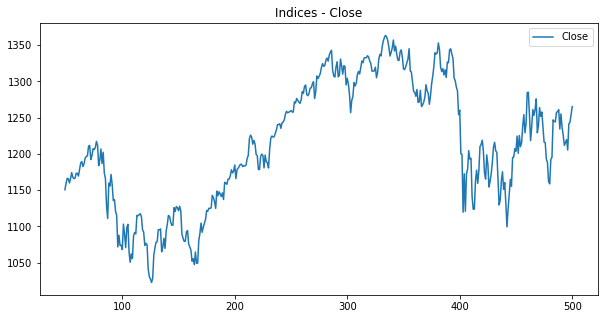

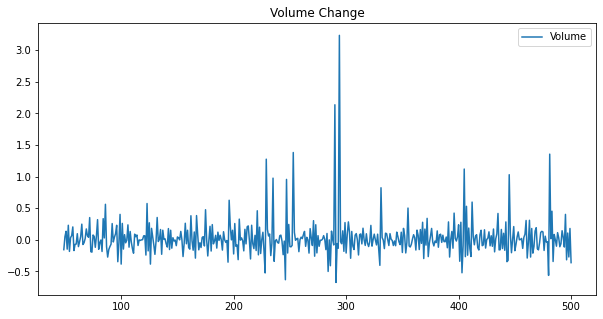

In [ ]:
from matplotlib import pyplot as plt
data.loc[0:500]["Close"].plot(kind="line", figsize=(10,5), title = "Indices - Close")
plt.legend()
plt.show()

data.loc[0:500]["Volume"].plot(kind="line", figsize=(10,5), title = "Volume Change")
plt.legend()
plt.show()

## Q1: Preparing the data

* Preprocess the data to a format that a neural network can use. Write a function `generate_data` to generate input and target samples as follows:
    - Set `2016-05-06` as a cut-off date and use all observations after this date for testing purpose (20% of the observations) and the remaining for training.
    - Transform the dataset by `z-normalization`. Since the features are in different scales, it is necessary to normalize them. A typical technique is z-normalization, $x^{'} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation. However, don't rely on batch normalization technique here, since a random batch cannot preserve the trending of the time series. Instead, for this step, do the following:
        - Fit a scaler using `only the training subset` (i.e calculate $\mu$ and $\sigma$). Your testing subset should `never` be exposed to the scaler or your training program. You can use package `sklearn.preprocessing.StandardScaler` for this step (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
        - Transform the entire dataset using the fitted scaler. If you want to transform the databack to the orginal, you can call the scaler's `inverse_transform` function. 

    - Slice the transformed dataset in every `L` days. For example, let ($x_i, y_i$) denote the $i$th sample. $x_i$ `= X[i : (i + L), feature_cols]` and $y_i$ `= Y[ i + L]`, where `X` is the transformed values of the dataframe, `feature_cols` are the columns you use as features, and Y is the transformed `Close` column or the binary target. You can use any column as a feature, or engineer new features.
    - Return transformed features, targets (for regression and binary classification) and scaler.
    
    

* Finally, split the sliced result into training and `testing` subsets based on the cut-off date. 

In [ ]:
# Define a function to generate samples 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

def transform_data(data, feature_cols, target_col, cut_off_index, lookback=5):
    
    X, Y, Y_binary, x_scaler, y_scaler = None, None, None, None, None
    
    # add your code here
    
    return X, Y, Y_binary, x_scaler, y_scaler

In [ ]:
# Transform data
np.set_printoptions(precision = 3)

feature_cols = ["Close","Volume", "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]  # feel free to add your own features, e.g. volume, day, week, etc.
target_col = "Close"
lookback = 5
train_test_cut_off = int(len(data)*0.8)


X, Y, Y_binary,x_scaler, y_scaler = transform_data(data, feature_cols, target_col, \
                                                   train_test_cut_off, lookback=lookback)
print("Total samples: {0}, train: {1}, test: {2}\n".\
      format(len(X), train_test_cut_off, len(X)- train_test_cut_off))
print("Show a few observations:")
print("Before transformation:")
print(data.iloc[0:7,0:3])
print("\nAfter transformation:")
print("X:")
print(X[0:2,:,0:2])
print("\nY - Regression:")
print(Y[0:2])
print("\nY - Classification: buy or hold")
print(Y_binary[0:2])

Total samples: 1930, train: 1548, test: 382

Show a few observations:
Before transformation:
         Date        Close    Volume
49 2010-03-15  1150.510010 -0.155038
50 2010-03-16  1159.459961  0.049389
51 2010-03-17  1166.209961  0.135803
52 2010-03-18  1165.829956 -0.146819
53 2010-03-19  1159.900024  0.230936
54 2010-03-22  1165.810059 -0.182397
55 2010-03-23  1174.170044  0.035188

After transformation:
X:
[[[-1.327 -0.796]
  [-1.301  0.138]
  [-1.282  0.533]
  [-1.283 -0.758]
  [-1.3    0.967]]

 [[-1.301  0.138]
  [-1.282  0.533]
  [-1.283 -0.758]
  [-1.3    0.967]
  [-1.283 -0.921]]]

Y - Regression:
[-1.283 -1.259]

Y - Classification: buy or hold
[1 1]


## Q2: Establish a naive baseline

Create a function `evaluate_naive_method` to estalish a baseline. Your objective is to beat the baseline by a RNN model. A simple baselien can be created as follows:
* Let's use the mean index of each observation as the baseline, i.e. the prediction for the next day is the mean of the indices in the last `L` days. For example, the prediction from sample `X[0]` in the above example (i.e. predicted index at day 6) is `X[0].mean(axis = 0)`, which is  `-1.2985`.
* Calculate the `mean absolute error (MAE)` and `accuracy` on the `testing data` as the baseline, i.e. the `MAE` error of the previous example is `abs(Y[0] - X[0]).mean(axis = 0)`. since `-1.295 > -1.3` (the index at day 5), the binary prediction is 1, which is correct.
* Feel free to use more advanced method, i.e. ARIMA, to creat a baseline. 

In [ ]:
# Define a function to calculate a baseline on the testing data

def evaluate_naive_method(test_X, test_Y, test_Y_binary):
    
    # add your code here
    
    
    return mae, acc

In [ ]:
test_X = X[train_test_cut_off:]
test_Y = Y[train_test_cut_off:]
test_Y_binary = Y_binary[train_test_cut_off:]
mae, acc = evaluate_naive_method(test_X[:,:,0], test_Y,test_Y_binary)
print("mae: {0:.3f}, acc: {1:.3f}".format(mae, acc))

mae: 0.036, acc: 0.531


## Q3:  Your first recurrent model

1. Create neural network models as follows:
    - The input to the model is the the training samples you created in Q1 
    - Add LSTM or GRU layers into the model
    - Add other appropriate layers, e.g. Dropout, regularizers.
    - Target and output layer:
        - Model A: the output predicts the `Close` index of the next day 
        - Model B: whether the `Close` index of the next day is higher than the current day
    - Carefully choose your hyperparameters, e.g. the number of hidden units in the LSTM/GRU layer, epochs, batch size etc.
    
    
2. Fit the models and plot the training history to ensure there is no overfitting. Calculate and print the testing MAE (or accuracy for the classification task)
    
    
3. Note, there are a large number of features in the dataset. `You don't have to use all of them. You can selectively pick a few of them which you think they would be helpful`.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [ ]:
class SP_Model(nn.Module):
    
    # add your model here
     

In [ ]:
class SP_dataset(Dataset):
    
    # define your dataset

In [ ]:
# Define a function to train the model 
def train_model(model, train_dataset, test_dataset, device, binary_pred = False,\
                lr=0.0005, epochs=20, batch_size=32):
    
    
    
    # define training function
   

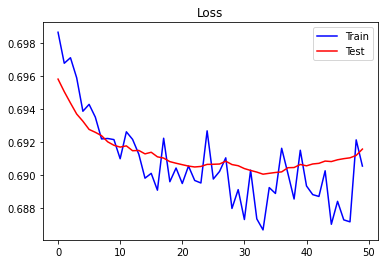

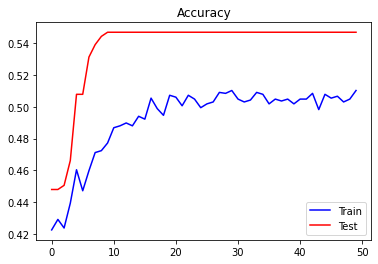

In [ ]:
# A sample of binary model training curves

plot_history(hista, binary_predict = True)

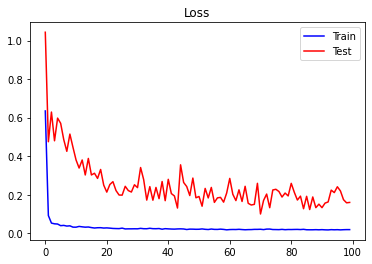

In [ ]:
# A sample of regression model training curve

plot_history(histb, binary_predict = False)

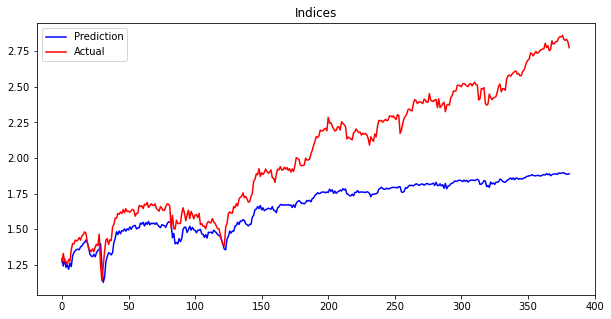

In [ ]:
# Show predicted indices vs. actual values
# the model cannot follow the trending


## Q4:  Advanced recurrent model to beat the baseline

Hope you have obtained a good model which can beat the Naive baseline! Unfortunately, very likely, you may have found that a simple LSTM model cannot beat the naive baseline. Now try to createa more advanced model which can exceed both of the models you have so far. A few options for you to consider:

- Select only useful features manually or use CNN (as the reference paper did)
- Use bidirectional RNN
- Go deeper by stacking RNN or dense layers
- Feature engineering with your knowledge in Financial Engineering
- Be creative as you can!

You can use include any mechanism you like into the model. The only requirement for this task is to have LSTM/GRU layers in your model.

In [ ]:
class SP_Model_Advanced(nn.Module):
    
   # define your model

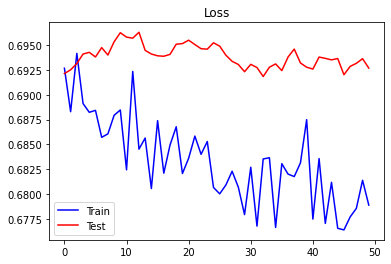

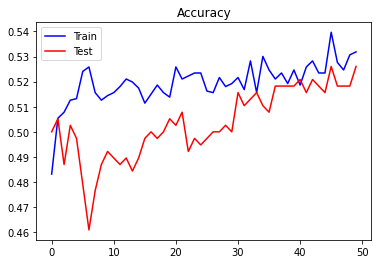

In [ ]:
# Binary model training curve

plot_history(hista, binary_predict = True)

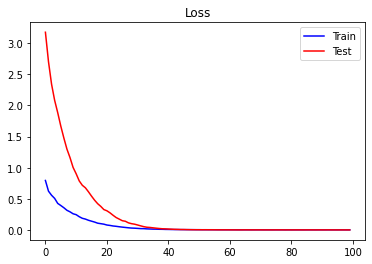

In [ ]:
# Regression model training curve

plot_history(histb, binary_predict = False)

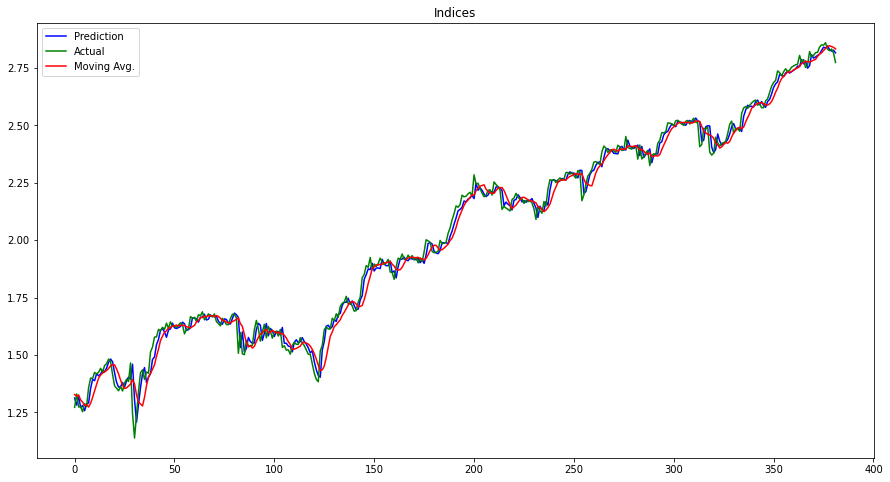

In [ ]:
# Show predicted indices vs. actual values


## Q5 (Bonus): Predict Indices in the next 5 days

---



Hope you have achieved your goal! So far we predict the indices for the next day. Can you modify your model to predict the indices for the next 5 days? i.e., give $[X_i, X_{i+1}, ..., X_{i+L}]$, preidct $[y_{i+L+1}, y_{i+L+2}, y_{i+L+3}, y_{i+L+4}, y_{i+L+5}]$. There is no need to predict the binary goal for this task.


Good luck!